<a href="https://colab.research.google.com/github/swha815/colab/blob/main/quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<H1>Neural Network Quantization</H1>

Porting floating-point (single-precision) numbers to integers (16 bits or less)


### I. Characteristics

#### Advantages

- Smaller memory footprint
- Faster computation (roughly 5X)

#### Disadvantages

- Loss of critical information when not done appropriately
- Extra burden of value conversion
  - Weights
    - Inference: can be pre-processed and used without modification during run-time
    - Training: must be quantized with every update (not true for Kahan summation-based methods)
  - Activation: input to NN must be quantized and output de-quantized

### II. Typical Process of NN Quantization

#### Prerequisite

1. Review the target HW architecture
1. Identify where MSB/LSB truncation error (round-off and clamping) occurs
1. Discard negligible truncation error
1. Consider techniques to minimize truncation error (i.e. BatchNorm folding)

#### Weights

1. **Profile** and collect statistics from kernel
1. **Analyze** gathered information
1. **Decide** quantization strategy
  - Granularity: layer-wise, output channel-wise, full channel-wise, etc
  - Symmetry: symmetric or asymmetric
  - Step-Size: uniform or non-uniform
1. **Simulate** HW kernel store by replacing original weights with quantized weights
  - Inference-only: quantize during pre-process stage
  - Training: quantize after every update

#### Activations

1. **Profile** and collect statistics from where truncation error is likely to occur (i.e. output feature map)
1. **Analyze** gathered information and try to find/fit an appropriate distribution
1. **Decide** quantization strategy (dependent on HW architecture)
  - Granularity: layer-wise, channel-wise, etc
  - Symmetry: symmetric or asymmetric
  - Step-Size: uniform (linear) or non-uniform (quadratic or LUT-based)
1. **Simulate** integer-based HW with _fake_ quantization layer

### III. Example

- Network: InceptionV3
- Platform: Keras on TensorFlow

Class Scores
ski                 : 0.80311
alp                 : 0.07034
ski_mask            : 0.00493
mountain_tent       : 0.00260
shovel              : 0.00147
--------------------------------------------------



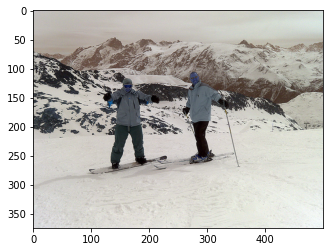

In [55]:
import tensorflow as tf
import tensorflow.keras.applications as keras_app
import tensorflow.keras.preprocessing as keras_prep
import urllib
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Prepare model for ImageNet classification
model = keras_app.InceptionV3(weights='imagenet')
prep_mod = keras_app.inception_v3
img_size = (299, 299)

# Load and pre-process an image
req = urllib.request.urlopen('https://raw.githubusercontent.com/swha815/colab/main/ILSVRC2012_val_00000002.JPEG')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = org_img = cv2.imdecode(arr, -1)
img = cv2.resize(img, img_size)
img = np.expand_dims(img, axis=0)
img = prep_mod.preprocess_input(img)

# Predict
pred = model.predict(img)
pred = keras_app.imagenet_utils.decode_predictions(pred, top=5)

# Score prediction
print('Class Scores')
print('=' * 50)

for p in pred[0]:
  print('{:20}: {:7.5f}'.format(p[1], p[2]))

print('-' * 50)
print()

plt.imshow(org_img)

### IV. Weight Quantization

### Activation Quantization